In [13]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [54]:
vb = pd.read_csv("../data/vb_data_3_numZone.csv")
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
# clipping
q_values[q_values>1] = 1
q_values[q_values<-1] = -1
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
q_tree = y_prob_tree[:,1]*2 - 1

q_diff = q_values-q_tree

In [17]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)

print(len(X.columns), 'columns in numerical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns=cols)

print(len(X.columns), 'columns in numerical dataframe after dummies')

93 columns in numerical dataframe
204 columns in numerical dataframe after dummies


In [57]:
# set up regressor tree for difference
for i in range(10,25,2):
    print('Checking max_depth =', i)
    clf = DecisionTreeRegressor(max_depth=i)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=q_diff, cv=5, n_jobs=4, scoring='r2')
    print('Mean cross validation accuracy:', scores.mean())

Checking max_depth = 10
Mean cross validation accuracy: 0.548338713342121
Checking max_depth = 12
Mean cross validation accuracy: 0.5933704349031578
Checking max_depth = 14
Mean cross validation accuracy: 0.5985582106546701
Checking max_depth = 16
Mean cross validation accuracy: 0.613865942839446
Checking max_depth = 18
Mean cross validation accuracy: 0.6129858506322418
Checking max_depth = 20
Mean cross validation accuracy: 0.6162823462257638
Checking max_depth = 22
Mean cross validation accuracy: 0.6079686102547751
Checking max_depth = 24
Mean cross validation accuracy: 0.6082037037712995


In [58]:
for i in range(50,1000,200):
    print('Checking min_samples_split =', i)
    clf = DecisionTreeRegressor(min_samples_split=i)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=q_diff, cv=5, n_jobs=4, scoring='r2')
    print('Mean cross validation accuracy:', scores.mean())

Checking min_samples_split = 50
Mean cross validation accuracy: 0.662436321810447
Checking min_samples_split = 250
Mean cross validation accuracy: 0.5269651753703142
Checking min_samples_split = 450
Mean cross validation accuracy: 0.4669270201600737
Checking min_samples_split = 650
Mean cross validation accuracy: 0.429525488785945
Checking min_samples_split = 850
Mean cross validation accuracy: 0.4035383457138262


In [62]:
clf = DecisionTreeRegressor(min_samples_split=50)
clf.fit(X, q_diff)
q_diff_pred = clf.predict(X)
print(metrics.r2_score(q_diff, q_diff_pred))

0.8494006303436836


In [33]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeRegressor()
parameters = {'min_samples_split':range(50,1000,200)}
model = GridSearchCV(clf, parameters, verbose=1, n_jobs=2)
model.fit(X, q_diff)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   57.8s finished


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=2,
             param_grid={'min_samples_split': range(50, 1000, 200)}, verbose=1)

In [36]:
q_diff_pred = model.predict(X)
print(metrics.r2_score(q_diff, q_diff_pred))

0.11687901202599771


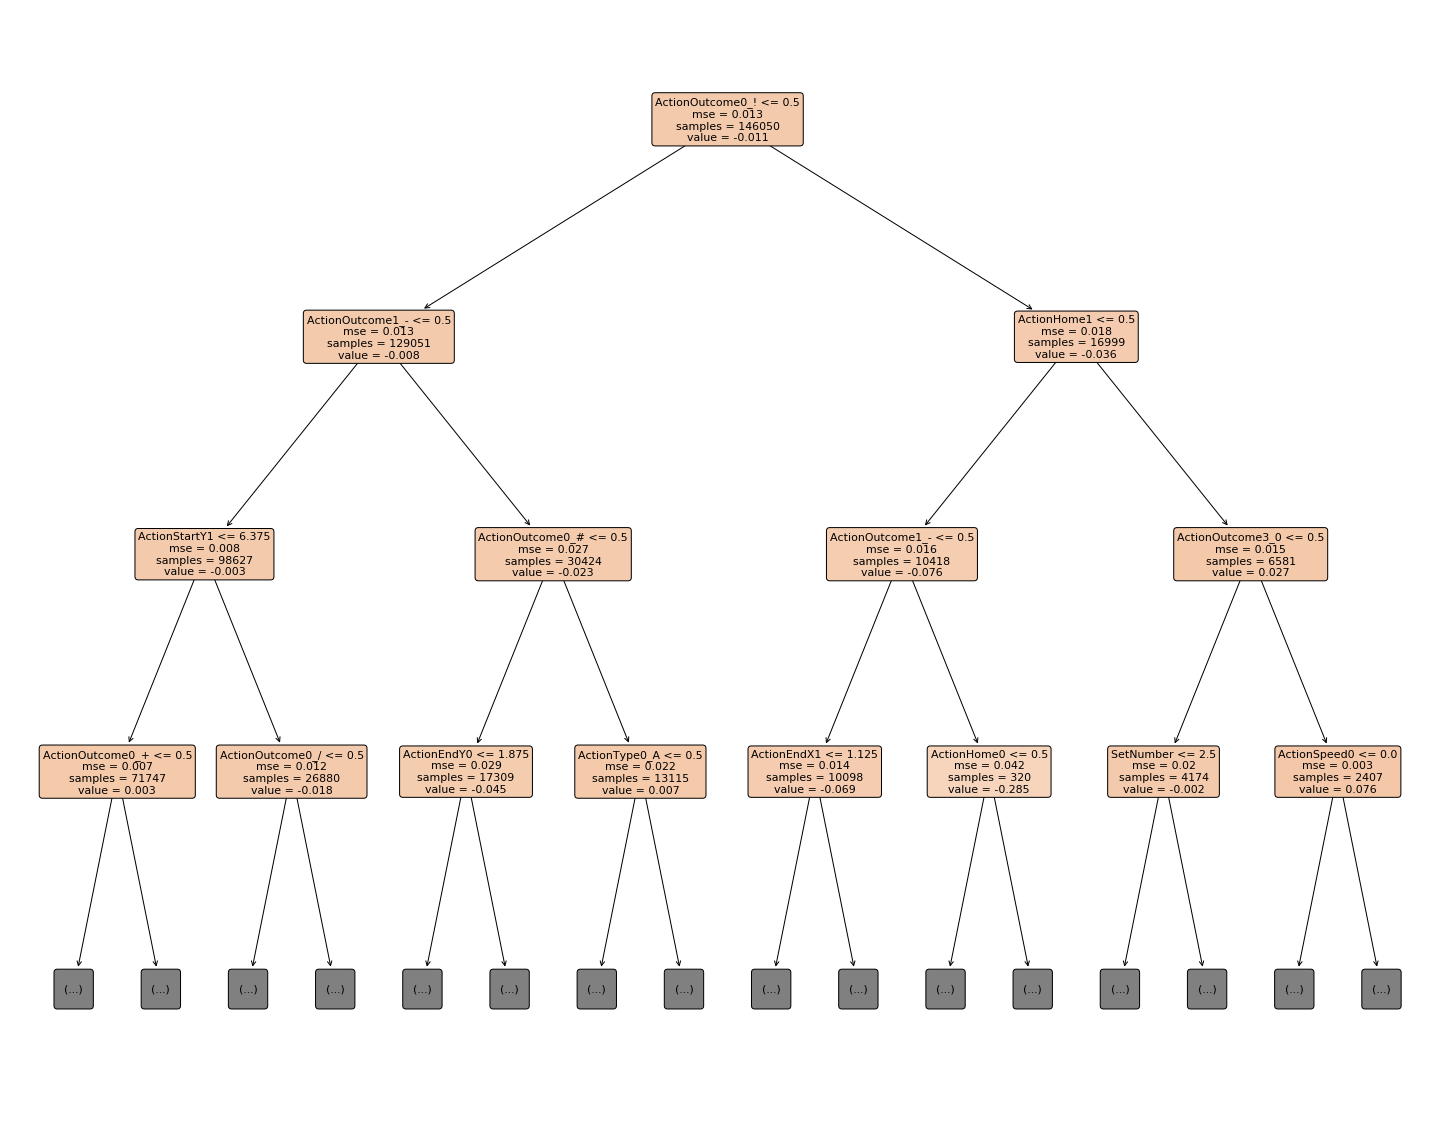

In [64]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,20))
a = plot_tree(clf, feature_names=X.columns, filled=True, rounded=True, fontsize=11, max_depth=3)
plt.show()

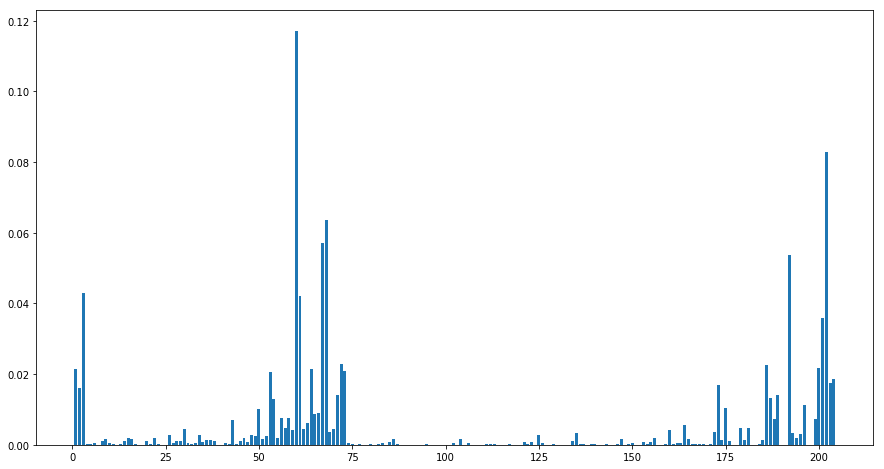

1 ActionHome1 0.117
2 ActionOutcome0_- 0.083
3 ActionAway0 0.064
4 ActionHome0 0.057
5 ActionType0_A 0.054
6 ScoreDiff 0.043
7 ActionAway1 0.042
8 ActionOutcome0_+ 0.036
9 ActionEndY0 0.023
10 ActionOutcome1_! 0.023
11 ActionOutcome0_# 0.022
12 ActionEndX1 0.021
13 SetNumber 0.021
14 ActionSpeed0 0.021
15 ActionHome2 0.021
16 ActionOutcome0_= 0.019
17 ActionOutcome0_/ 0.018
18 ActionOutcome2_! 0.017
19 ScoreMax 0.016
20 ActionOutcome1_- 0.014
21 ActionEndX0 0.014
22 ActionOutcome1_# 0.013
23 ActionAway2 0.013
24 ActionType0_F 0.011
25 ActionOutcome2_+ 0.010


In [65]:
plt.figure(figsize=(15,8))
plt.bar(range(1,205),clf.feature_importances_)
plt.show()

indxs = clf.feature_importances_.argsort()[-25:][::-1]
for i in range(1,len(indxs)+1):
    idx = indxs[i-1]
    print('%d %s %.3f' % (i, X.columns[idx], clf.feature_importances_[idx]))

In [78]:
mean_overall = np.mean(q_diff)
print('Mean overall: %.6f' % (mean_overall))
for action in ['S','R','E','A','B','D']:
    for outcome in ['=','-','/','!','+','#']:
        cond = (vb.ActionOutcome0 == outcome) & (vb.ActionType0 == action)
        if sum(cond)>0:
            print('Mean diff with condition %s%s: %.6f' % (action, outcome, np.abs(mean_overall-np.mean(q_diff[cond]))))

Mean overall: -0.010900
Mean diff with condition S=: 0.012513
Mean diff with condition S-: 0.003529
Mean diff with condition S!: 0.106635
Mean diff with condition S+: 0.063015
Mean diff with condition S#: 0.008348
Mean diff with condition R=: 0.010537
Mean diff with condition R-: 0.011207
Mean diff with condition R!: 0.039987
Mean diff with condition R+: 0.023123
Mean diff with condition R#: 0.005440
Mean diff with condition E=: 0.001985
Mean diff with condition E-: 0.019726
Mean diff with condition E+: 0.008710
Mean diff with condition E#: 0.000060
Mean diff with condition A=: 0.014864
Mean diff with condition A-: 0.029009
Mean diff with condition A/: 0.039428
Mean diff with condition A!: 0.021616
Mean diff with condition A+: 0.008108
Mean diff with condition A#: 0.037012
Mean diff with condition B=: 0.025219
Mean diff with condition B-: 0.011642
Mean diff with condition B!: 0.030128
Mean diff with condition B+: 0.053661
Mean diff with condition B#: 0.012589
Mean diff with condition D

In [90]:
cond = (vb.ActionOutcome0 == '!') & (vb.ActionType0 == 'S') & (vb.ActionHome0 == 1)
print(np.mean(q_values[cond]))
print(np.mean(q_tree[cond]))
print(np.mean(q_diff[cond]))
cond = (vb.ActionOutcome0 == '!') & (vb.ActionType0 == 'S') & (vb.ActionAway0 == 0)
print()
print(np.mean(q_values[cond]))
print(np.mean(q_tree[cond]))
print(np.mean(q_diff[cond]))

-0.11581368
0.10344054690126647
-0.21925421762011127

-0.11581368
0.10344054690126647
-0.21925421762011127
